In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

%matplotlib inline

In [2]:
PATH = Path('.')

In [3]:
device = "cuda:6" if torch.cuda.is_available() else "cpu"

In [4]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

In [5]:
train_ds = datasets.MNIST(PATH / "MNIST", train=True, transform=tfms, download=True)
test_ds = datasets.MNIST(PATH / "MNIST", train=False, transform=tfms, download=True)

In [6]:
train_dl = data.DataLoader(train_ds, batch_size=36)
test_dl = data.DataLoader(test_ds, batch_size=36, shuffle=False)

In [7]:
def plot_mnist(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

In [8]:
def plot_losses(trn_losses, tst_losses):
    plt.figure(figsize=(12,6))
    plt.plot(tst_losses, color='green', label="test")
    plt.plot(trn_losses, color='blue', label="train")
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.legend()
    plt.show()

In [9]:
class ConvLayer(nn.Module):
    def __init__(self, sz, bn=False, dp=False, a_fn=F.relu, pl = nn.MaxPool2d(2, stride=2), **kwargs):
        super().__init__()
        self.a_fn = a_fn
        layers = []
        conv = nn.Conv2d(sz[0], sz[1], sz[2], **kwargs)
        nn.init.kaiming_normal_(conv.weight, mode='fan_out', nonlinearity='relu')
        layers.append(conv)
        if pl:
            layers.append(pl)
        if bn:
            layers.append(nn.BatchNorm2d(sz[1]))
        if dp:
            layers.append(nn.Dropout2d())
        #layers.append(a_fn)
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.a_fn(self.model(x))

In [10]:
class ConvTLayer(nn.Module):
    def __init__(self, sz, bn=False, dp=False, a_fn=nn.ReLU(), **kwargs):
        super().__init__()
        layers = []
        conv = nn.ConvTranspose2d(sz[0], sz[1], sz[2], **kwargs)
        nn.init.kaiming_normal_(conv.weight, mode='fan_out', nonlinearity='relu')
        layers.append(conv)
        if bn:
            layers.append(nn.BatchNorm2d(sz[1]))
        if dp:
            layers.append(nn.Dropout2d())
        layers.append(a_fn)
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [11]:
class LinearLayer(nn.Module):
    def __init__(self, sz, bn=False, dp=False, a_fn=nn.ReLU(), **kwargs):
        super().__init__()
        layers = []
        for i in range(len(sz)-2):
            fc = nn.Linear(sz[i], sz[i+1])
            nn.init.kaiming_uniform_(fc.weight)
            layers.append(fc)
            if bn:
                layers.append(nn.BatchNorm1d(sz[i+1]))
            if dp:
                layers.append(nn.Dropout())
            layers.append(a_fn)
        fc = nn.Linear(sz[-2], sz[-1])
        nn.init.kaiming_uniform_(fc.weight)
        layers.append(fc)
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [12]:
class ConvolutionalClassifier(nn.Module):
    def __init__(self, linear_sizes=(1024,10), bn=False, dp=False):
        super().__init__()
        self.linear_sizes = linear_sizes
        self.name = f'ConvClf BN={bn} DP={dp} FC={self.linear_sizes}'
        self.cnn = nn.Sequential(
            ConvLayer((1,16,3), bn=bn, dp=dp, padding=1),
            ConvLayer((16,32,3), bn=bn, dp=dp, padding=1),
            ConvLayer((32,64,3), bn=bn, dp=dp, padding=1),
            ConvLayer((64,128,3), bn=bn, dp=dp, padding=1)
        )
        self.clf = nn.Sequential(
            LinearLayer([128*1*1, *linear_sizes], bn=bn, dp=dp),
        )
        
        self.optim = optim.Adam(self.parameters(), lr=1e-4)
        self._loss = None
        
    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.shape[0], -1)
        x = self.clf(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [13]:
models = [ConvolutionalClassifier().to(device), 
          ConvolutionalClassifier(bn=True).to(device),
          ConvolutionalClassifier(bn=True, dp=True).to(device)]

In [14]:
for m in models:
    print(f"\n------------- {m.name} -------------\n")
    print(m)


------------- ConvClf BN=False DP=False FC=(1024, 10) -------------

ConvolutionalClassifier(
  (cnn): Sequential(
    (0): ConvLayer(
      (model): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvLayer(
      (model): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): ConvLayer(
      (model): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (3): ConvLayer(
      (model): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [15]:
def train(models, train_dl, test_dl):
    train_loss = [0.]*len(models)
    train_size = len(train_dl)
    
    test_loss = [0.]*len(models)
    test_size = len(test_dl)
    
    for data, target in train_dl:
        data = data.to(device)
        target = target.to(device)
        for i, m in enumerate(models):
            m.train()
            m.optim.zero_grad()
            output = m(data)
            loss = m.loss(output, target)
            loss.backward()
            m.optim.step()
            train_loss[i] += m._loss.item()
        
    correct = [0]*len(models)
    total = [0]*len(models)
    for data, target in test_dl:
        data = data.to(device)
        target = target.to(device)
        for i, m in enumerate(models):
            m.eval()
            output = m(data)
            loss = m.loss(output, target)
            _, pred = torch.max(output, dim=1)
            correct[i] +=(pred==target).sum().item()
            total[i] += len(data)
            test_loss[i] += m._loss.item()

    print(f"Epoch {epoch}:")
    for i, m in enumerate(models):
        train_loss[i] /= train_size
        test_loss[i] /= test_size
        print("  Loss for {0:45s}: {1:2.5f} / {2:2.5f}, Accuracy {3}/{4}".format(
            m.name, train_loss[i], test_loss[i], correct[i], total[i]))
        
    return zip(train_loss, test_loss)

In [16]:
train_losses = [[] for i in range(len(models))]
test_losses = [[] for i in range(len(models))]

Epoch 1:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.42834 / 0.11906, Accuracy 9602/10000
  Loss for ConvClf BN=True DP=False FC=(1024, 10)       : 0.37776 / 0.08556, Accuracy 9744/10000
  Loss for ConvClf BN=True DP=True FC=(1024, 10)        : 2.34445 / 2.54327, Accuracy 1135/10000
Epoch 2:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.09470 / 0.06940, Accuracy 9776/10000
  Loss for ConvClf BN=True DP=False FC=(1024, 10)       : 0.07940 / 0.05231, Accuracy 9834/10000
  Loss for ConvClf BN=True DP=True FC=(1024, 10)        : 1.91110 / 2.57966, Accuracy 1614/10000
Epoch 3:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.06665 / 0.05840, Accuracy 9815/10000
  Loss for ConvClf BN=True DP=False FC=(1024, 10)       : 0.04466 / 0.04285, Accuracy 9865/10000
  Loss for ConvClf BN=True DP=True FC=(1024, 10)        : 1.35121 / 1.65490, Accuracy 4327/10000
Epoch 4:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.05217 / 0.05054, Accuracy 9842/

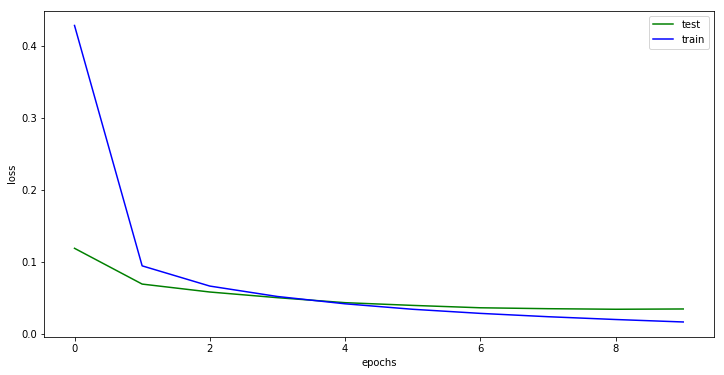


------------- ConvClf BN=True DP=False FC=(1024, 10) -------------



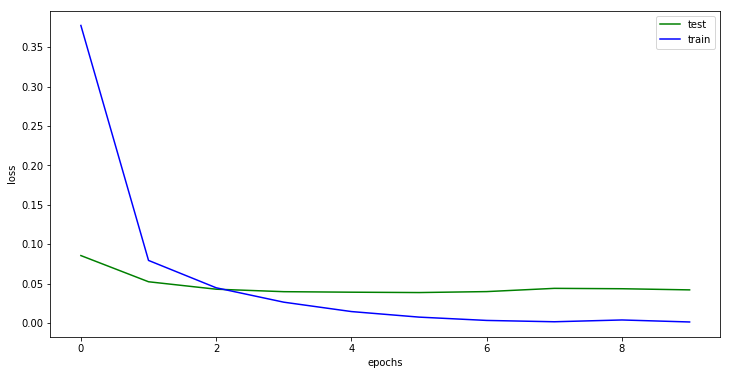


------------- ConvClf BN=True DP=True FC=(1024, 10) -------------



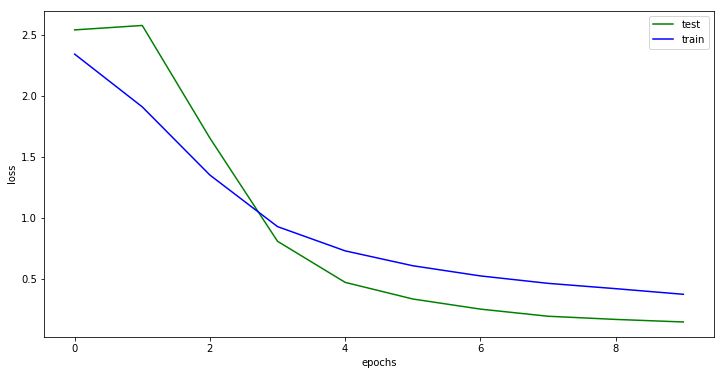

Epoch 11:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.01383 / 0.03156, Accuracy 9904/10000
  Loss for ConvClf BN=True DP=False FC=(1024, 10)       : 0.00050 / 0.04147, Accuracy 9885/10000
  Loss for ConvClf BN=True DP=True FC=(1024, 10)        : 0.34859 / 0.12782, Accuracy 9590/10000
Epoch 12:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.01112 / 0.03250, Accuracy 9911/10000
  Loss for ConvClf BN=True DP=False FC=(1024, 10)       : 0.00017 / 0.04292, Accuracy 9887/10000
  Loss for ConvClf BN=True DP=True FC=(1024, 10)        : 0.32642 / 0.11248, Accuracy 9633/10000
Epoch 13:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.00899 / 0.03412, Accuracy 9909/10000
  Loss for ConvClf BN=True DP=False FC=(1024, 10)       : 0.00008 / 0.04380, Accuracy 9892/10000
  Loss for ConvClf BN=True DP=True FC=(1024, 10)        : 0.30292 / 0.10294, Accuracy 9677/10000
Epoch 14:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.00786 / 0.03279, Accuracy 9

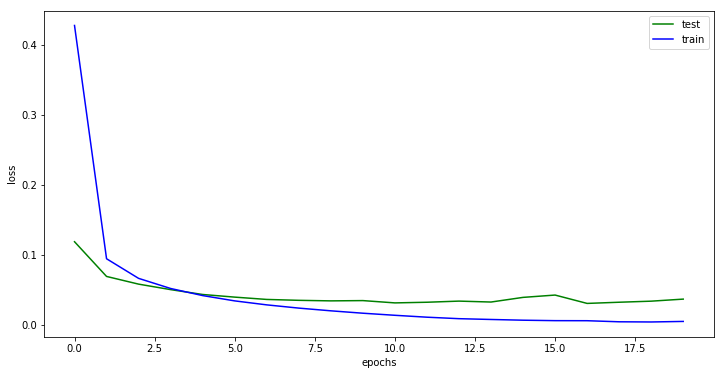


------------- ConvClf BN=True DP=False FC=(1024, 10) -------------



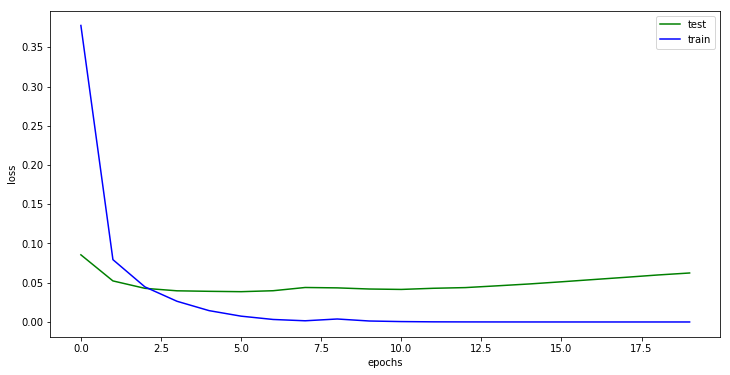


------------- ConvClf BN=True DP=True FC=(1024, 10) -------------



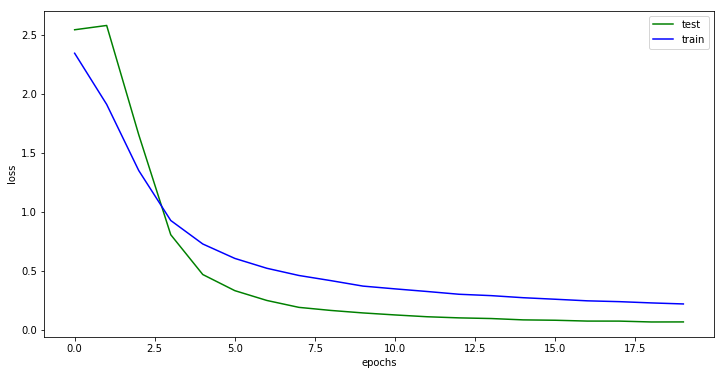

Epoch 21:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.00391 / 0.03836, Accuracy 9910/10000
  Loss for ConvClf BN=True DP=False FC=(1024, 10)       : 0.00000 / 0.06524, Accuracy 9897/10000
  Loss for ConvClf BN=True DP=True FC=(1024, 10)        : 0.21587 / 0.06250, Accuracy 9789/10000
Epoch 22:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.00367 / 0.03686, Accuracy 9910/10000
  Loss for ConvClf BN=True DP=False FC=(1024, 10)       : 0.00000 / 0.06726, Accuracy 9898/10000
  Loss for ConvClf BN=True DP=True FC=(1024, 10)        : 0.20806 / 0.06035, Accuracy 9799/10000
Epoch 23:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.00333 / 0.03670, Accuracy 9910/10000
  Loss for ConvClf BN=True DP=False FC=(1024, 10)       : 0.00233 / 0.09432, Accuracy 9833/10000
  Loss for ConvClf BN=True DP=True FC=(1024, 10)        : 0.20243 / 0.06082, Accuracy 9804/10000
Epoch 24:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.00334 / 0.03874, Accuracy 9

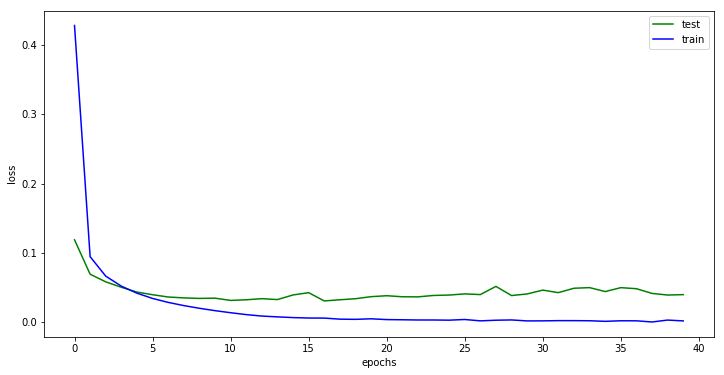


------------- ConvClf BN=True DP=False FC=(1024, 10) -------------



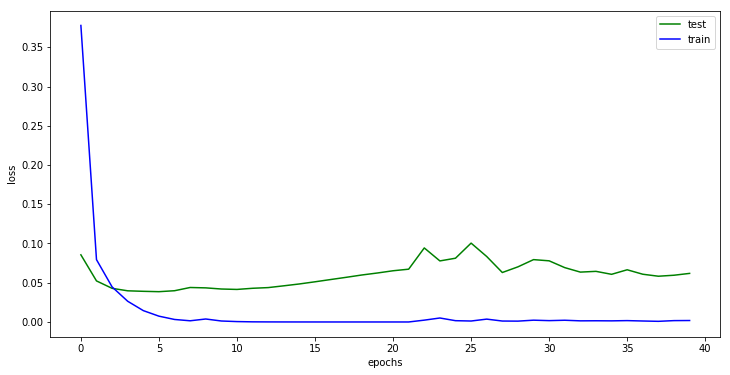


------------- ConvClf BN=True DP=True FC=(1024, 10) -------------



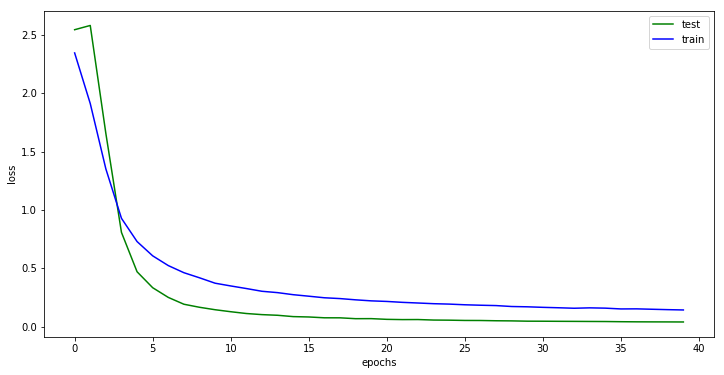

Epoch 41:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.00153 / 0.04737, Accuracy 9903/10000
  Loss for ConvClf BN=True DP=False FC=(1024, 10)       : 0.00077 / 0.06275, Accuracy 9900/10000
  Loss for ConvClf BN=True DP=True FC=(1024, 10)        : 0.14186 / 0.03847, Accuracy 9875/10000
Epoch 42:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.00121 / 0.05130, Accuracy 9901/10000
  Loss for ConvClf BN=True DP=False FC=(1024, 10)       : 0.00094 / 0.06517, Accuracy 9891/10000
  Loss for ConvClf BN=True DP=True FC=(1024, 10)        : 0.14177 / 0.03909, Accuracy 9857/10000
Epoch 43:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.00241 / 0.04394, Accuracy 9918/10000
  Loss for ConvClf BN=True DP=False FC=(1024, 10)       : 0.00173 / 0.06361, Accuracy 9892/10000
  Loss for ConvClf BN=True DP=True FC=(1024, 10)        : 0.13774 / 0.03839, Accuracy 9872/10000
Epoch 44:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.00020 / 0.03841, Accuracy 9

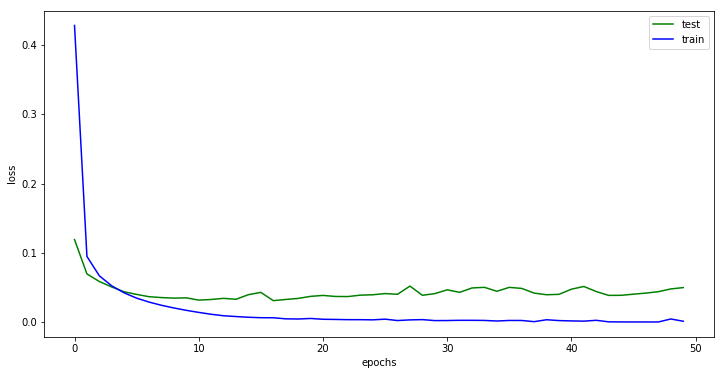


------------- ConvClf BN=True DP=False FC=(1024, 10) -------------



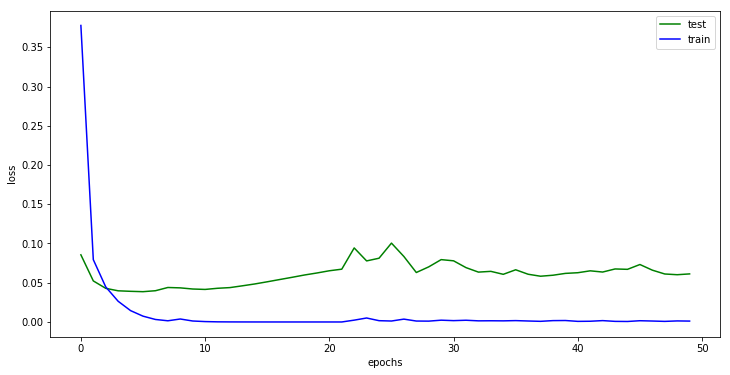


------------- ConvClf BN=True DP=True FC=(1024, 10) -------------



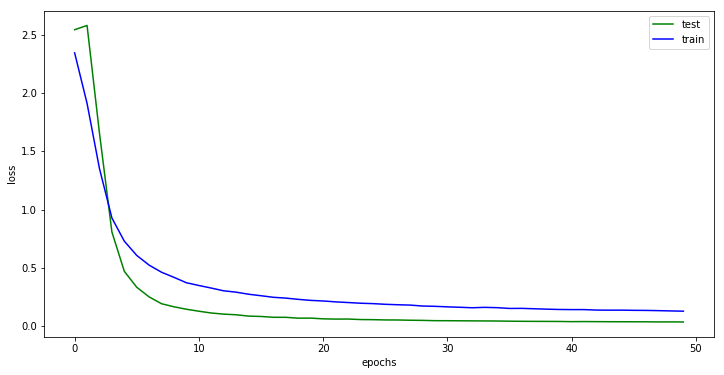

Epoch 51:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.00167 / 0.05080, Accuracy 9901/10000
  Loss for ConvClf BN=True DP=False FC=(1024, 10)       : 0.00077 / 0.05489, Accuracy 9909/10000
  Loss for ConvClf BN=True DP=True FC=(1024, 10)        : 0.12859 / 0.03504, Accuracy 9879/10000
Epoch 52:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.00125 / 0.05722, Accuracy 9910/10000
  Loss for ConvClf BN=True DP=False FC=(1024, 10)       : 0.00012 / 0.05637, Accuracy 9912/10000
  Loss for ConvClf BN=True DP=True FC=(1024, 10)        : 0.12779 / 0.03519, Accuracy 9879/10000
Epoch 53:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.00067 / 0.04565, Accuracy 9924/10000
  Loss for ConvClf BN=True DP=False FC=(1024, 10)       : 0.00174 / 0.06275, Accuracy 9898/10000
  Loss for ConvClf BN=True DP=True FC=(1024, 10)        : 0.12716 / 0.03490, Accuracy 9883/10000
Epoch 54:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.00011 / 0.04860, Accuracy 9

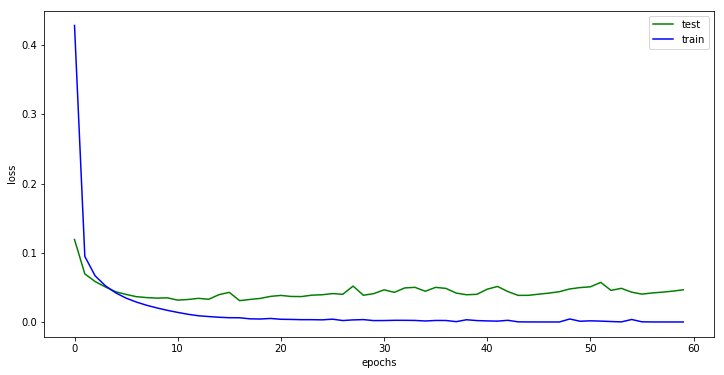


------------- ConvClf BN=True DP=False FC=(1024, 10) -------------



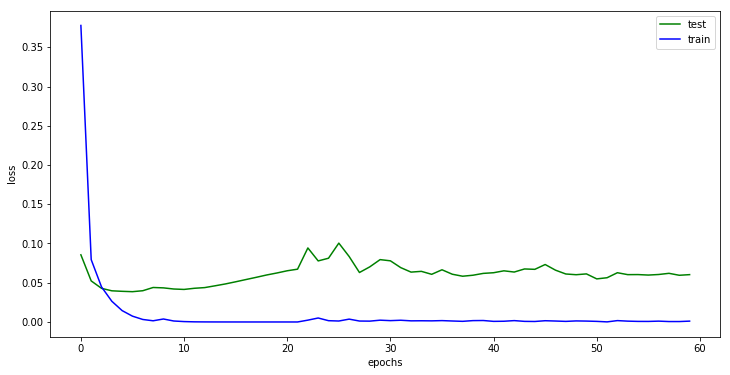


------------- ConvClf BN=True DP=True FC=(1024, 10) -------------



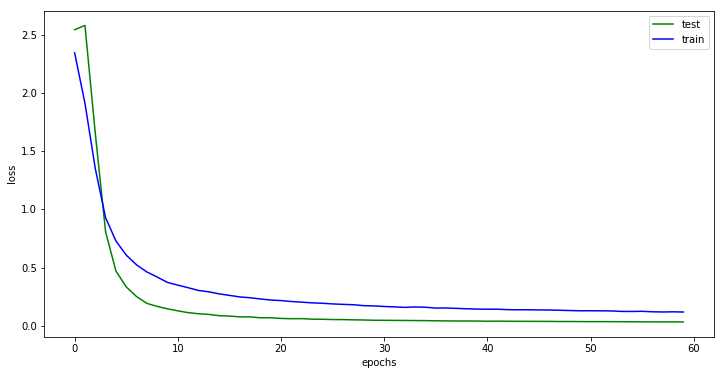

Epoch 65:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.00088 / 0.04883, Accuracy 9921/10000
  Loss for ConvClf BN=True DP=False FC=(1024, 10)       : 0.00034 / 0.06453, Accuracy 9895/10000
  Loss for ConvClf BN=True DP=True FC=(1024, 10)        : 0.11352 / 0.03166, Accuracy 9889/10000
Epoch 66:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.00018 / 0.04350, Accuracy 9931/10000
  Loss for ConvClf BN=True DP=False FC=(1024, 10)       : 0.00004 / 0.05763, Accuracy 9912/10000
  Loss for ConvClf BN=True DP=True FC=(1024, 10)        : 0.11171 / 0.03130, Accuracy 9895/10000
Epoch 67:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.00001 / 0.04269, Accuracy 9928/10000
  Loss for ConvClf BN=True DP=False FC=(1024, 10)       : 0.00001 / 0.05748, Accuracy 9912/10000
  Loss for ConvClf BN=True DP=True FC=(1024, 10)        : 0.11139 / 0.03018, Accuracy 9901/10000
Epoch 68:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.00000 / 0.04358, Accuracy 9

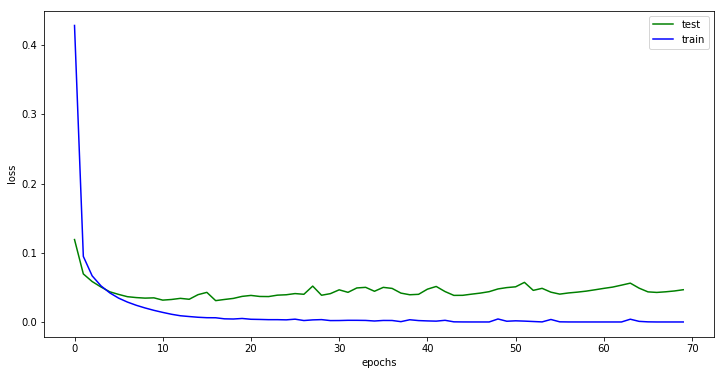


------------- ConvClf BN=True DP=False FC=(1024, 10) -------------



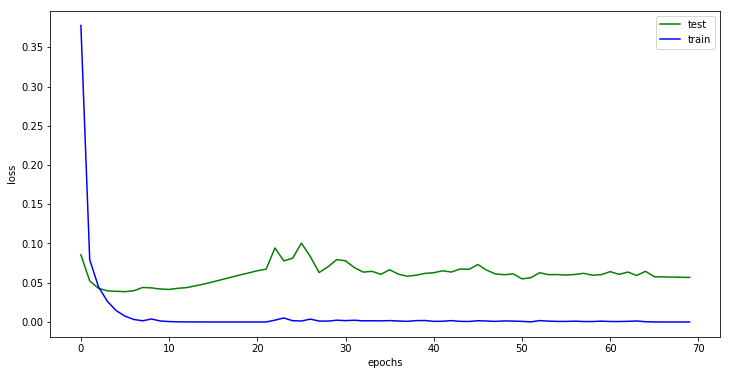


------------- ConvClf BN=True DP=True FC=(1024, 10) -------------



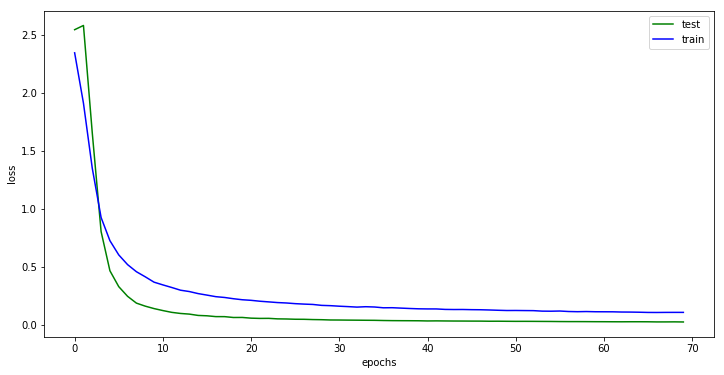

Epoch 71:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.00000 / 0.04863, Accuracy 9930/10000
  Loss for ConvClf BN=True DP=False FC=(1024, 10)       : 0.00000 / 0.05663, Accuracy 9920/10000
  Loss for ConvClf BN=True DP=True FC=(1024, 10)        : 0.11128 / 0.02986, Accuracy 9900/10000
Epoch 72:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.00000 / 0.05101, Accuracy 9930/10000
  Loss for ConvClf BN=True DP=False FC=(1024, 10)       : 0.00000 / 0.05680, Accuracy 9918/10000
  Loss for ConvClf BN=True DP=True FC=(1024, 10)        : 0.11150 / 0.02905, Accuracy 9909/10000
Epoch 73:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.00000 / 0.05377, Accuracy 9932/10000
  Loss for ConvClf BN=True DP=False FC=(1024, 10)       : 0.00000 / 0.05730, Accuracy 9921/10000
  Loss for ConvClf BN=True DP=True FC=(1024, 10)        : 0.10808 / 0.02847, Accuracy 9904/10000
Epoch 74:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.00000 / 0.05661, Accuracy 9

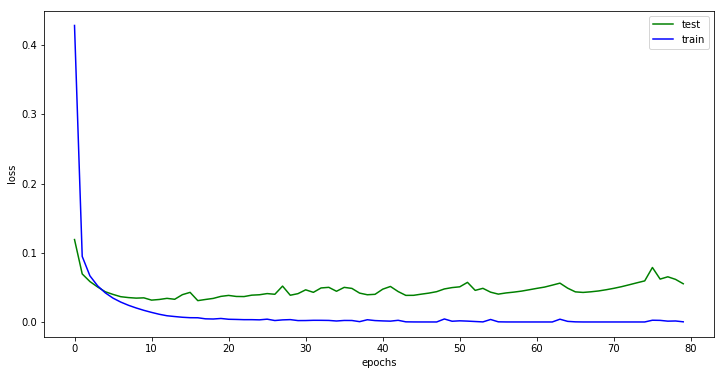


------------- ConvClf BN=True DP=False FC=(1024, 10) -------------



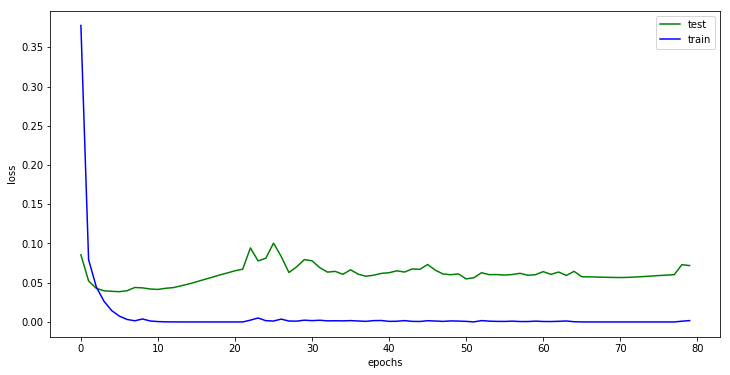


------------- ConvClf BN=True DP=True FC=(1024, 10) -------------



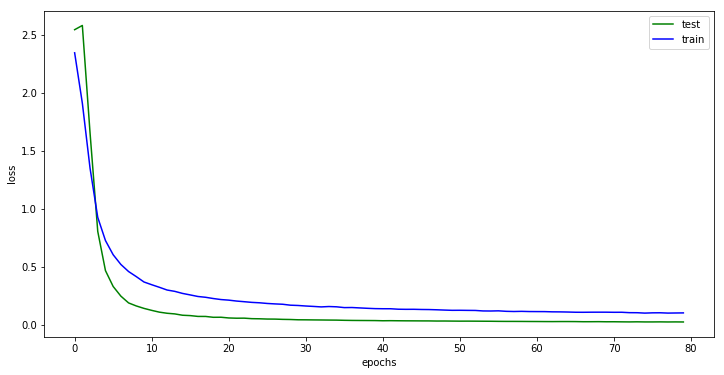

Epoch 81:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.00211 / 0.05584, Accuracy 9914/10000
  Loss for ConvClf BN=True DP=False FC=(1024, 10)       : 0.00106 / 0.07589, Accuracy 9905/10000
  Loss for ConvClf BN=True DP=True FC=(1024, 10)        : 0.10363 / 0.02823, Accuracy 9897/10000
Epoch 82:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.00232 / 0.05197, Accuracy 9912/10000
  Loss for ConvClf BN=True DP=False FC=(1024, 10)       : 0.00065 / 0.06357, Accuracy 9912/10000
  Loss for ConvClf BN=True DP=True FC=(1024, 10)        : 0.10314 / 0.02786, Accuracy 9900/10000
Epoch 83:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.00112 / 0.06774, Accuracy 9899/10000
  Loss for ConvClf BN=True DP=False FC=(1024, 10)       : 0.00033 / 0.06386, Accuracy 9909/10000
  Loss for ConvClf BN=True DP=True FC=(1024, 10)        : 0.10311 / 0.02740, Accuracy 9903/10000
Epoch 84:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.00143 / 0.05289, Accuracy 9

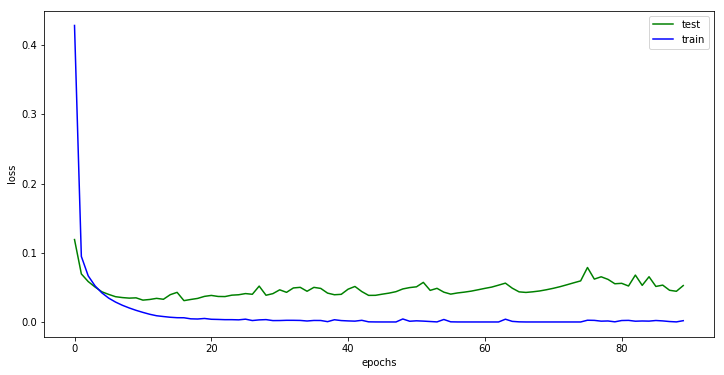


------------- ConvClf BN=True DP=False FC=(1024, 10) -------------



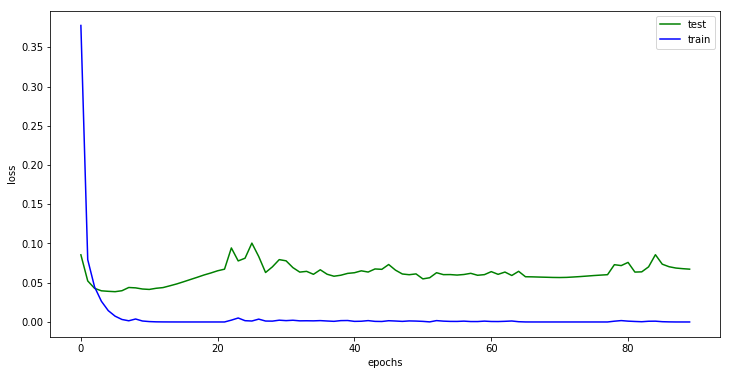


------------- ConvClf BN=True DP=True FC=(1024, 10) -------------



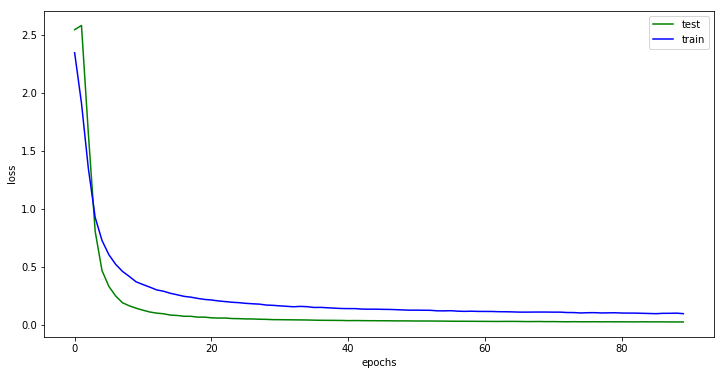

Epoch 91:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.00042 / 0.05218, Accuracy 9922/10000
  Loss for ConvClf BN=True DP=False FC=(1024, 10)       : 0.00000 / 0.06661, Accuracy 9914/10000
  Loss for ConvClf BN=True DP=True FC=(1024, 10)        : 0.09606 / 0.02692, Accuracy 9905/10000
Epoch 92:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.00278 / 0.05646, Accuracy 9909/10000
  Loss for ConvClf BN=True DP=False FC=(1024, 10)       : 0.00000 / 0.06591, Accuracy 9915/10000
  Loss for ConvClf BN=True DP=True FC=(1024, 10)        : 0.09631 / 0.02691, Accuracy 9913/10000
Epoch 93:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.00029 / 0.05877, Accuracy 9914/10000
  Loss for ConvClf BN=True DP=False FC=(1024, 10)       : 0.00000 / 0.06531, Accuracy 9918/10000
  Loss for ConvClf BN=True DP=True FC=(1024, 10)        : 0.09792 / 0.02655, Accuracy 9906/10000
Epoch 94:
  Loss for ConvClf BN=False DP=False FC=(1024, 10)      : 0.00158 / 0.06565, Accuracy 9

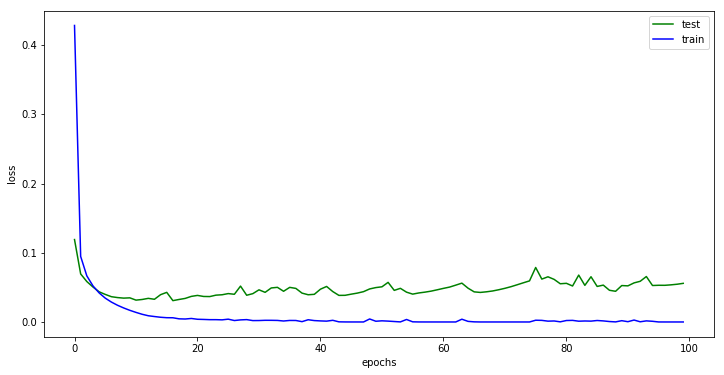


------------- ConvClf BN=True DP=False FC=(1024, 10) -------------



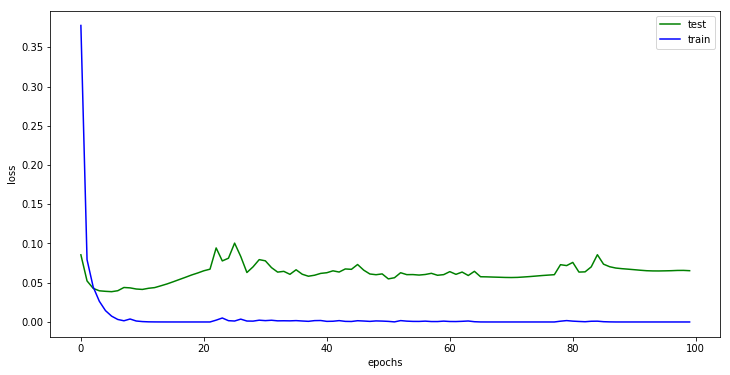


------------- ConvClf BN=True DP=True FC=(1024, 10) -------------



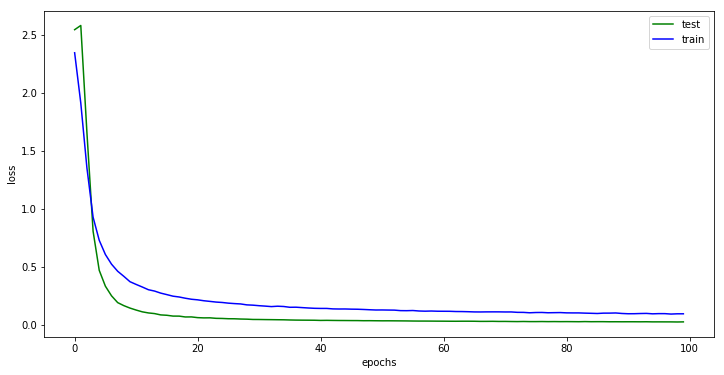

CPU times: user 45min 33s, sys: 38.5 s, total: 46min 12s
Wall time: 45min 59s


In [17]:
%%time
for epoch in range(1, 101):
    losses = train(models, train_dl, test_dl)
    
    for i, (trn, tst) in enumerate(losses):
        train_losses[i].append(trn)
        test_losses[i].append(tst)
    
    if epoch % 10 == 0:
        for i, m in enumerate(models):
            print(f"\n------------- {m.name} -------------\n")
            plot_losses(train_losses[i], test_losses[i])



In [18]:
for m in models:
    torch.save(m.state_dict(), PATH / f'{m.name}.model')

### Train loss

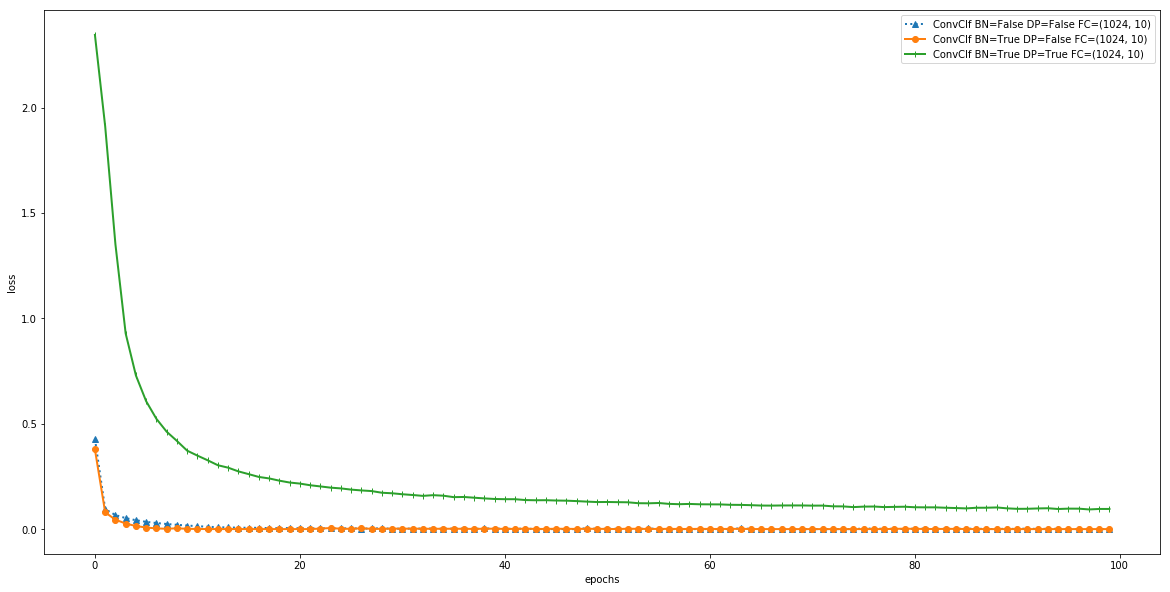

In [19]:

plt.figure(figsize=(20,10))

for i, m in enumerate(models):
    line = train_losses[i]
    if "FC=None" in m.name:
        plt.plot(line, label=m.name, linestyle='-',
        linewidth=4)
    elif "BN=True" in m.name and "DP=False" in m.name:
        plt.plot(line, label=m.name, marker='o', linestyle='-',
        linewidth=2, markersize=6)
    elif "BN=True" in m.name and "DP=True" in m.name:
        plt.plot(line, label=m.name, marker='|', linestyle='-',
        linewidth=2, markersize=6)
    else:
        plt.plot(line, label=m.name, marker='^', linestyle=':',
        linewidth=2, markersize=6)
        
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend()
plt.show()

### Test loss

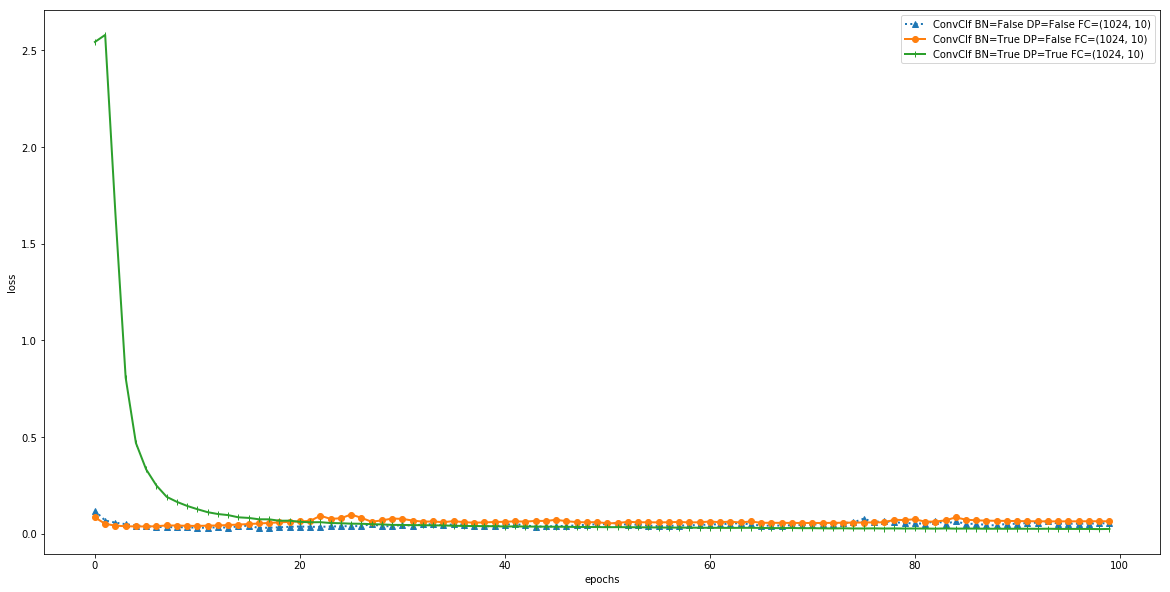

In [20]:
plt.figure(figsize=(20,10))

for i, m in enumerate(models):
    line = test_losses[i]
    if "FC=None" in m.name:
        plt.plot(line, label=m.name, linestyle='-',
        linewidth=4)
    elif "BN=True" in m.name and "DP=False" in m.name:
        plt.plot(line, label=m.name, marker='o', linestyle='-',
        linewidth=2, markersize=6)
    elif "BN=True" in m.name and "DP=True" in m.name:
        plt.plot(line, label=m.name, marker='|', linestyle='-',
        linewidth=2, markersize=6)
    else:
        plt.plot(line, label=m.name, marker='^', linestyle=':',
        linewidth=2, markersize=6)
        
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [21]:
class FitImageToMaxActivationModel(nn.Module):
    def __init__(self, image, n=0, a_fn=F.relu, clip_fn=F.tanh):
        super().__init__()
        self.n = n
        self.a_fn = a_fn
        self.image = nn.Parameter(image)
        self.optim = optim.Adam(self.parameters(), lr=1e-4)
        self._loss = None
        self.clip_fn = clip_fn if clip_fn else lambda x: x
        
    def forward(self, encoder):
        x = self.image
        out = self.a_fn(encoder(self.clip_fn(x)))
        return out
    
    def loss(self, output):
        self._loss = -output[:,self.n,:,:].abs().sum()
        return self._loss

In [22]:
def fit_image_to_activation(sz, n, encoder, n_iter = 10_001, n_print = 10_000):
    torch.manual_seed(42)
    
    origin = torch.zeros(*sz)
    
    nn.init.kaiming_uniform_(origin)
    
    encoder.eval()

    ms = {
        'target': FitImageToMaxActivationModel(torch.tensor(origin).to(device), n, a_fn = F.relu)
    }

    opt_losses = [[] for i in range(len(ms))]

    for m in ms.values():
        m.to(device).train()

    for i in range(1, n_iter):
        losses = [0.0]*len(ms)
        for j , m in enumerate(ms.values()):
            m.optim.zero_grad()
            out = m(encoder)
            loss = m.loss(out)
            loss.backward()
            m.optim.step()
            losses[j]+=loss.item()
        if i % n_print == 0:
            for k in range(len(ms)):
                opt_losses[k].append(losses[k])
            s = ["\t{0:10s} = {1:2.10f}\n".format(m, losses[j]) for j , m in enumerate(ms)]
            line = f"{int(i/1000)}K iteration loss: \n{' '.join(s)}"
            print(line)
            losses = [0.0]*len(ms)
    for m in ms.values():
        m.eval()
        target_imgs = {k: m.image.detach() for k, m in ms.items()}

    print(f'Max activation pattern for neuron #{n}')
    target = target_imgs['target']
    plot_mnist(F.tanh(target).data.cpu().numpy(), (1,1))
    return target

In [23]:
encoder = models[1].cnn[0]
encoder.eval()
encoder

ConvLayer(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

100K iteration loss: 
	target     = -0.5808308125

Max activation pattern for neuron #1


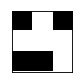

100K iteration loss: 
	target     = 0.0000000000

Max activation pattern for neuron #2


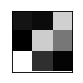

100K iteration loss: 
	target     = 0.0000000000

Max activation pattern for neuron #3


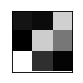

100K iteration loss: 
	target     = -0.8710993528

Max activation pattern for neuron #4


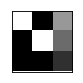

100K iteration loss: 
	target     = 0.0000000000

Max activation pattern for neuron #5


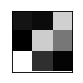

100K iteration loss: 
	target     = 0.0000000000

Max activation pattern for neuron #6


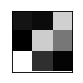

100K iteration loss: 
	target     = 0.0000000000

Max activation pattern for neuron #7


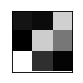

100K iteration loss: 
	target     = -2.2767050266

Max activation pattern for neuron #8


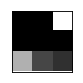

100K iteration loss: 
	target     = 0.0000000000

Max activation pattern for neuron #9


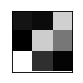

100K iteration loss: 
	target     = -2.9834783077

Max activation pattern for neuron #10


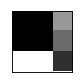

100K iteration loss: 
	target     = -0.9182758927

Max activation pattern for neuron #11


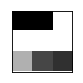

100K iteration loss: 
	target     = -3.0779991150

Max activation pattern for neuron #12


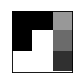

100K iteration loss: 
	target     = -2.2290973663

Max activation pattern for neuron #13


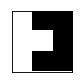

100K iteration loss: 
	target     = -1.5888410807

Max activation pattern for neuron #14


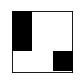

100K iteration loss: 
	target     = -0.3436452448

Max activation pattern for neuron #15


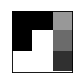

In [24]:
targets1 = []
for i in range(16):
    t = fit_image_to_activation((1,1,3,3), i, encoder, n_iter=100_001, n_print=100_000)
    targets1.append(t)

In [25]:
encoder = nn.Sequential(
    models[1].cnn[0],
    nn.ReLU(),
    models[1].cnn[1]
) 
encoder.eval()
encoder

Sequential(
  (0): ConvLayer(
    (model): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): ReLU()
  (2): ConvLayer(
    (model): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
)

100K iteration loss: 
	target     = 0.0000000000

Max activation pattern for neuron #0


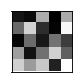

100K iteration loss: 
	target     = 0.0000000000

Max activation pattern for neuron #1


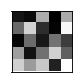

100K iteration loss: 
	target     = 0.0000000000

Max activation pattern for neuron #2


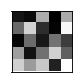

100K iteration loss: 
	target     = -2.2517099380

Max activation pattern for neuron #4


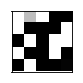

100K iteration loss: 
	target     = -2.3836336136

Max activation pattern for neuron #5


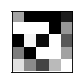

100K iteration loss: 
	target     = -1.1679891348

Max activation pattern for neuron #6


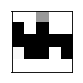

100K iteration loss: 
	target     = 0.0000000000

Max activation pattern for neuron #7


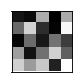

100K iteration loss: 
	target     = -1.6019780636

Max activation pattern for neuron #8


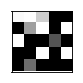

100K iteration loss: 
	target     = 0.0000000000

Max activation pattern for neuron #9


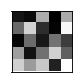

100K iteration loss: 
	target     = 0.0000000000

Max activation pattern for neuron #10


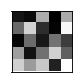

100K iteration loss: 
	target     = -1.7080773115

Max activation pattern for neuron #11


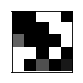

100K iteration loss: 
	target     = -1.0036940575

Max activation pattern for neuron #12


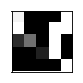

100K iteration loss: 
	target     = 0.0000000000

Max activation pattern for neuron #13


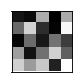

100K iteration loss: 
	target     = 0.0000000000

Max activation pattern for neuron #14


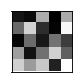

100K iteration loss: 
	target     = -2.6975197792

Max activation pattern for neuron #15


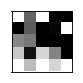

100K iteration loss: 
	target     = 0.0000000000

Max activation pattern for neuron #16


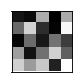

100K iteration loss: 
	target     = -1.5990798473

Max activation pattern for neuron #17


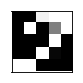

100K iteration loss: 
	target     = 0.0000000000

Max activation pattern for neuron #18


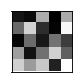

100K iteration loss: 
	target     = 0.0000000000

Max activation pattern for neuron #19


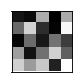

100K iteration loss: 
	target     = -2.7405078411

Max activation pattern for neuron #20


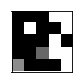

100K iteration loss: 
	target     = 0.0000000000

Max activation pattern for neuron #21


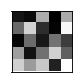

100K iteration loss: 
	target     = 0.0000000000

Max activation pattern for neuron #22


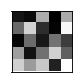

100K iteration loss: 
	target     = -1.9358768463

Max activation pattern for neuron #23


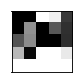

100K iteration loss: 
	target     = -1.9247527122

Max activation pattern for neuron #24


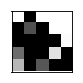

100K iteration loss: 
	target     = 0.0000000000

Max activation pattern for neuron #25


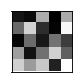

100K iteration loss: 
	target     = 0.0000000000

Max activation pattern for neuron #26


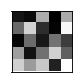

100K iteration loss: 
	target     = -1.0148493052

Max activation pattern for neuron #27


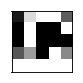

100K iteration loss: 
	target     = 0.0000000000

Max activation pattern for neuron #28


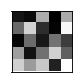

100K iteration loss: 
	target     = 0.0000000000

Max activation pattern for neuron #29


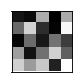

100K iteration loss: 
	target     = -0.9162312746

Max activation pattern for neuron #30


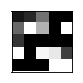

100K iteration loss: 
	target     = 0.0000000000

Max activation pattern for neuron #31


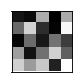

In [26]:
targets2 = []
for i in range(32):
    t = fit_image_to_activation((1,1,5,5), i, encoder, n_iter=100_001, n_print=100_000)
    targets2.append(t)

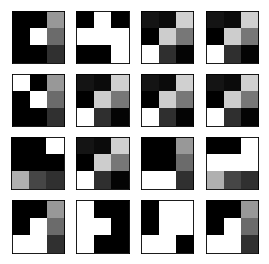

In [27]:
plot_mnist(F.tanh(torch.cat(targets1)).data.cpu().numpy(), (4,4))

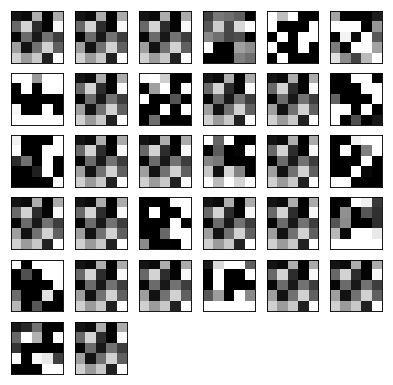

In [28]:
plot_mnist(F.tanh(torch.cat(targets2)).data.cpu().numpy(), (6,6))